Используя данные датасета, найти повторяющиеся закономерности или тенденции в дневных ценах.

Набор данных предоставляет детальную информацию об истории цен Биткойна , позволяя пользователям отслеживать ежеминутные изменения его рыночной стоимости.

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# Загрузка данных
data = pd.read_csv("bitcoin_2017_to_2023.csv", parse_dates=['timestamp'])
data = data.set_index('timestamp')

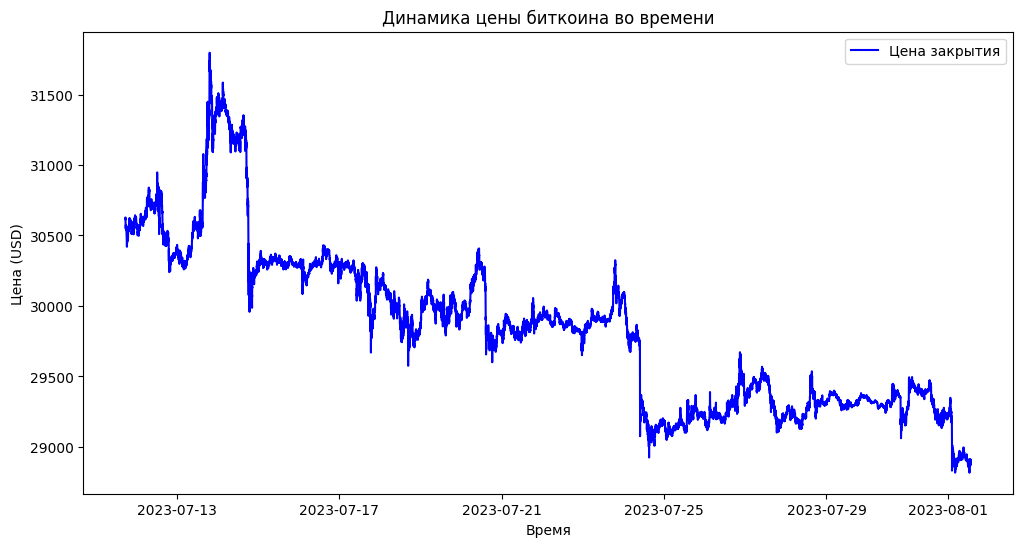

In [5]:
# Визуализация временного ряда цен биткойна
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Цена закрытия', color='blue')
plt.title('Динамика цены биткоина во времени')
plt.xlabel('Время')
plt.ylabel('Цена (USD)')
plt.legend()
plt.show()

In [7]:
# Разделение данных на обучающий и тестовый наборы
train_size = int(len(data) * 0.2)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [8]:
# Автоматический выбор параметров ARIMA с измененными параметрами
model = auto_arima(
    train['close'],
    suppress_warnings=True,
    seasonal=True,
    stepwise=True,
    approximation=False,
    max_order=None,
    start_p=1, start_d=1, start_q=1, # Установка начальных значений параметров ARIMA
    max_p=1.5, max_d=1.5, max_q=1.5,  # Ограничение параметров ARIMA
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41710.430, Time=6.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41744.728, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41718.537, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41716.392, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41742.886, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41708.578, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=41714.530, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=41716.675, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 9.896 seconds


In [9]:
# Обучение ARIMA модели
model.fit(train['close'])

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
# Прогнозирование будущих значений
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True, alpha=0.05)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
# Расчет метрик
mae = mean_absolute_error(test['close'], forecast)
mse = mean_squared_error(test['close'], forecast)
rmse = mean_squared_error(test['close'], forecast, squared=False)  # RMSE

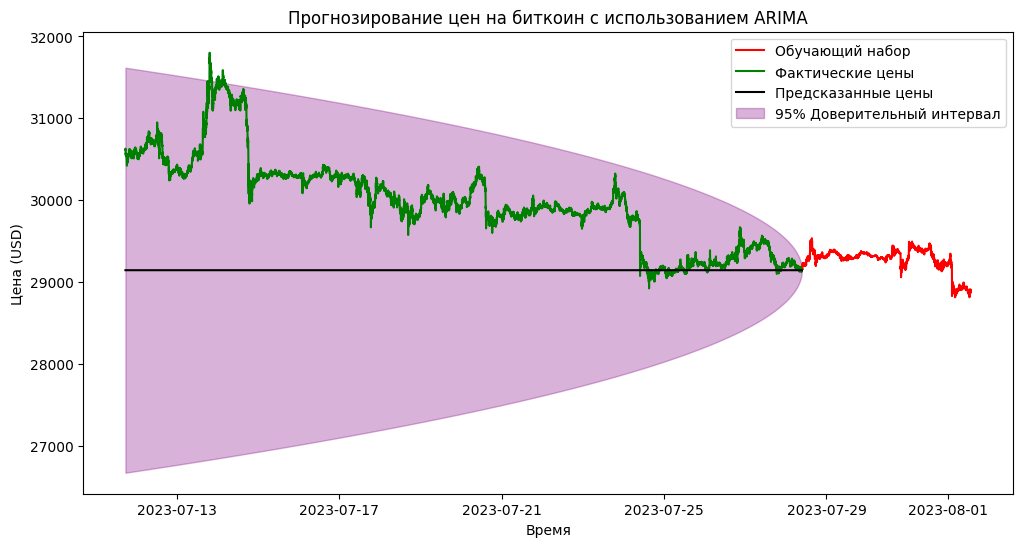

In [12]:
# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(train['close'], label='Обучающий набор', color='red')
plt.plot(test.index, test['close'], label='Фактические цены', color='green')
plt.plot(test.index, forecast, label='Предсказанные цены', color='black')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='purple', alpha=0.3, label='95% Доверительный интервал')
plt.title('Прогнозирование цен на биткоин с использованием ARIMA')
plt.xlabel('Время')
plt.ylabel('Цена (USD)')
plt.legend()
plt.show()

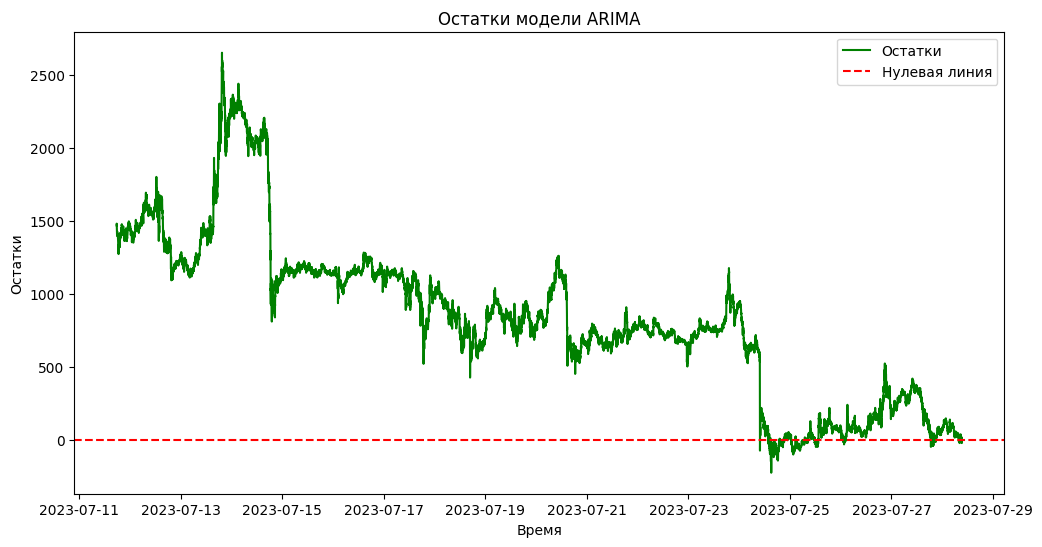

In [13]:
# Анализ остатков
residuals = test['close'].values - forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals, label='Остатки', color='green')
plt.axhline(y=0, color='r', linestyle='--', label='Нулевая линия')
plt.title('Остатки модели ARIMA')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.legend()
plt.show()

In [14]:
# Вывод временных меток, цен закрытия и предсказанных цен
results = pd.DataFrame({
    'Временная метка': test.index,
    'Фактическое закрытие': test['close'].values,
    'Предсказанное закрытие': forecast[:len(test)],
    'Нижняя граница доверительного интервала': conf_int[:, 0],
    'Верхняя граница доверительного интервала': conf_int[:, 1]
})

In [15]:
# Вывод результатов
print(results)

          Временная метка  Фактическое закрытие  Предсказанное закрытие  \
5995  2023-07-28 09:24:00              29146.84            29145.022663   
5996  2023-07-28 09:23:00              29140.25            29145.123262   
5997  2023-07-28 09:22:00              29140.00            29145.058941   
5998  2023-07-28 09:21:00              29147.40            29145.100066   
5999  2023-07-28 09:20:00              29145.99            29145.073771   
...                   ...                   ...                     ...   
29971 2023-07-11 17:48:00              30592.28            29145.084027   
29972 2023-07-11 17:47:00              30600.00            29145.084027   
29973 2023-07-11 17:46:00              30602.25            29145.084027   
29974 2023-07-11 17:45:00              30627.99            29145.084027   
29975 2023-07-11 17:44:00              30615.99            29145.084027   

       Нижняя граница доверительного интервала  \
5995                              29129.648374   

In [16]:
# Вывод результатов модели
print("Сводка модели ARIMA:")
print(model.summary())

Сводка модели ARIMA:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5995
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -20851.289
Date:                Mon, 11 Dec 2023   AIC                          41708.578
Time:                        14:48:26   BIC                          41728.673
Sample:                             0   HQIC                         41715.557
                               - 5995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6394      0.047    -13.511      0.000      -0.732      -0.547
ma.L1          0.7009      0.046     15.299      0.000       0.611       0.791
sigma2        61.5310      0.13

Из анализа таблицы summary() и коэффициентов модели SARIMA(1, 1, 1) следует, что:

1) AR (AutoRegressive) коэффициент (ar.L1):
*   Значение коэффициента: -0.6394
*   P-значение (P>|z|): 0.000 (статистически значимое)
Этот коэффициент связан с зависимостью между текущим значением ряда и его предыдущими значениями. Значение -0.6394 указывает на негативную авторегрессию.

2) MA (Moving Average) коэффициент (ma.L1):
*   Значение коэффициента: 0.7009
*   P-значение (P>|z|): 0.000 (статистически значимое)
Этот коэффициент связан с зависимостью между текущим значением ошибки модели и предыдущими значениями ошибок. Значение 0.7009 указывает на положительное скользящее среднее.

Таким образом, модель SARIMA учитывает авторегрессию и скользящее среднее для прогнозирования временного ряда цен на биткоин. Значения P-значений ниже уровня значимости 0.05 говорят о статистической значимости этих зависимостей.

In [18]:
# Вывод метрик
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 844.2980309937114
Mean Squared Error (MSE): 1011182.8228681477
Root Mean Squared Error (RMSE): 1005.5758662916229


Средняя абсолютная ошибка (MAE): 844.3

MAE представляет собой среднее абсолютных значений ошибок прогноза. Значение MAE в данном контексте означает, что средняя ошибка прогноза составляет примерно 844.3 доллара.

Средняя квадратичная ошибка (MSE): 1,011,182.8

MSE представляет собой среднее квадратов ошибок прогноза. Значение MSE указывает на среднеквадратичное отклонение прогноза от фактических значений, и в данном случае, оно составляет примерно 1,011,182.8.

Корень из среднеквадратичной ошибки (RMSE): 1005.6

RMSE представляет собой корень из средней квадратичной ошибки и также предоставляет меру среднего отклонения. Значение RMSE в данном контексте равно примерно 1005.6 долларам.